In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
import shutil
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructType,StructField,DoubleType, StringType, IntegerType

In [2]:
# 创建SparkSession
spark = SparkSession.builder.config('spark.ui.port', 4055).appName("pyspark SQL basic example") .config("spark.sql.debug.maxToStringFields", "1000").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/06 02:32:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/06 02:32:37 WARN Utils: Service 'SparkUI' could not bind on port 4055. Attempting port 4056.
25/04/06 02:32:37 WARN Utils: Service 'SparkUI' could not bind on port 4056. Attempting port 4057.
25/04/06 02:32:37 WARN Utils: Service 'SparkUI' could not bind on port 4057. Attempting port 4058.


In [3]:
# Define schema
schema = StructType([
  StructField('customerID', StringType()),
  StructField('gender', StringType()),
  StructField('seniorCitizen', DoubleType()),
  StructField('partner', StringType()),
  StructField('dependents', StringType()),
  StructField('tenure', DoubleType()),
  StructField('phoneService', StringType()),
  StructField('multipleLines', StringType()),
  StructField('internetService', StringType()), 
  StructField('onlineSecurity', StringType()),
  StructField('onlineBackup', StringType()),
  StructField('deviceProtection', StringType()),
  StructField('techSupport', StringType()),
  StructField('streamingTV', StringType()),
  StructField('streamingMovies', StringType()),
  StructField('contract', StringType()),
  StructField('paperlessBilling', StringType()),
  StructField('paymentMethod', StringType()),
  StructField('monthlyCharges', DoubleType()),
  StructField('totalCharges', DoubleType()),
  StructField('churn', StringType())
  ])


In [4]:
#读取数据
bronze_df = spark.read.csv('Telco-Customer-Churn.csv', header=True, schema=schema)
bronze_df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|seniorCitizen|partner|dependents|tenure|phoneService|   multipleLines|internetService|onlineSecurity|onlineBackup|deviceProtection|techSupport|streamingTV|streamingMovies|      contract|paperlessBilling|       paymentMethod|monthlyCharges|totalCharges|churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [6]:
#进行数据清洗，转换数据
silver_df = bronze_df.withColumn('churn',when(col('churn') == 'Yes',1).when(col('churn') == 'No',0).otherwise('Unknown'))\
                     .filter(col('contract') == 'Month-to-month')\
                     .filter(col('internetService') != 'No')
silver_df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|seniorCitizen|partner|dependents|tenure|phoneService|   multipleLines|internetService|onlineSecurity|onlineBackup|deviceProtection|techSupport|streamingTV|streamingMovies|      contract|paperlessBilling|       paymentMethod|monthlyCharges|totalCharges|churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [7]:
#导入后序的包
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test


In [11]:
#创建表
silver_df.createOrReplaceTempView('silver_monthly_customers')
bronze_df.createOrReplaceTempView('bronze_customers')
spark.sql("SELECT * FROM silver_monthly_customers").show()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|seniorCitizen|partner|dependents|tenure|phoneService|   multipleLines|internetService|onlineSecurity|onlineBackup|deviceProtection|techSupport|streamingTV|streamingMovies|      contract|paperlessBilling|       paymentMethod|monthlyCharges|totalCharges|churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|          0.0|    Yes|        No|   1.0|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [12]:
telco_pd = spark.table('silver_monthly_customers').toPandas()

In [13]:
# 通过客户的 ​**tenure（在网时长，即客户使用服务的时间）​** 和 ​**churn（是否流失的标记）​** 数据，回答以下问题：

from pyspark.sql.functions import col
from lifelines import KaplanMeierFitter

# 提取列并转换为Pandas Series
T = silver_df.select(col("tenure").cast("float")).toPandas()["tenure"]  # 转换为Pandas Series
C = silver_df.select(col("churn").cast("float")).toPandas()["churn"]    # 转换为Pandas Series

# 检查数据类型是否正确
print(T.dtype)  # 应该输出 float64
print(C.dtype)  # 应该输出 float64

# 使用lifelines拟合模型
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=C)  # 直接传递Pandas Series

float32
float32


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve: Population level'}, xlabel='timeline'>

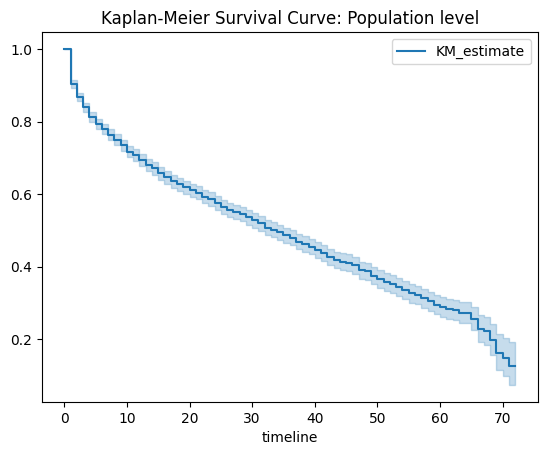

In [14]:
kmf.plot(title='Kaplan-Meier Survival Curve: Population level')

In [16]:
print(kmf.median_survival_time_)

34.0


In [18]:
#定义画图的方法
# ​绘制分组的 Kaplan-Meier 生存曲线：根据指定列 col（如性别、套餐类型等分类变量），对每个分组（例如男/女、套餐A/B/C）分别拟合生存曲线，并绘制在同一图中，
# 便于直观比较不同群体的生存（留存）差异。
def plot_km(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(telco_pd['tenure'], telco_pd[col], telco_pd['churn'])
  return log_rank.summary
# ​执行 Log-rank 检验：统计检验不同分组的生存曲线是否存在显著差异。
# ​检验假设：
# 原假设（H0）：所有分组的生存曲线相同（无差异）。
# 备择假设（H1）：至少有一个分组的生存曲线不同。

,,test_statistic,p,-log2(p)
Female,Male,1.61011,0.204476,2.289995


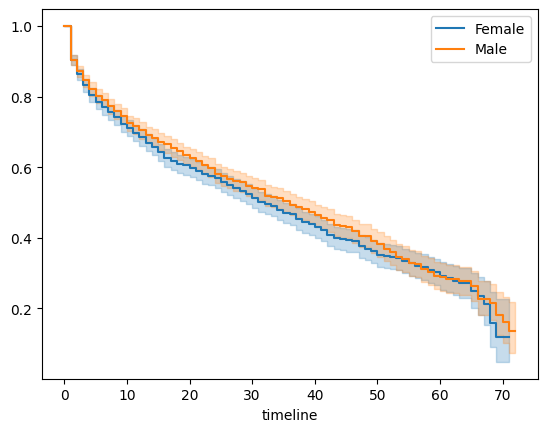

In [19]:
# 生存分析（Kaplan-Meier曲线）及Log-Rank检验
# ------------------------------------------------------------

# 分析性别（gender）对客户流失的影响
plot_km('gender')            # 绘制不同性别的生存曲线（留存率对比）
print_logrank('gender')      # 检验性别间流失率的统计学差异

,,test_statistic,p,-log2(p)
No,Yes,75.800079,3.138886e-18,58.144453


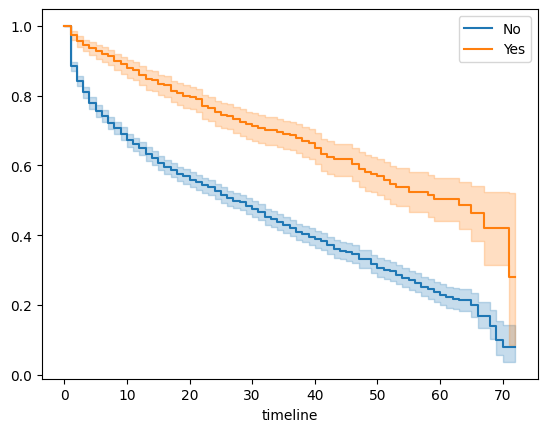

In [20]:
# 分析是否开通在线安全服务（onlineSecurity）与客户流失的关系
plot_km('onlineSecurity')    # 比较开通与未开通用户的留存差异
print_logrank('onlineSecurity')


,,test_statistic,p,-log2(p)
0.0,1.0,49.027784,2.523624e-12,38.52764


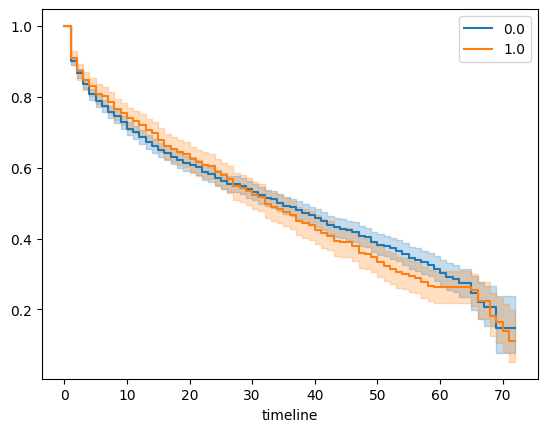

In [21]:
# 分析是否为老年人（seniorCitizen）对流失的影响
plot_km('seniorCitizen')     # 老年客户与非老年客户的生存曲线对比
print_logrank('seniorCitizen')


,,test_statistic,p,-log2(p)
No,Yes,257.844159,5.063437e-58,190.331712


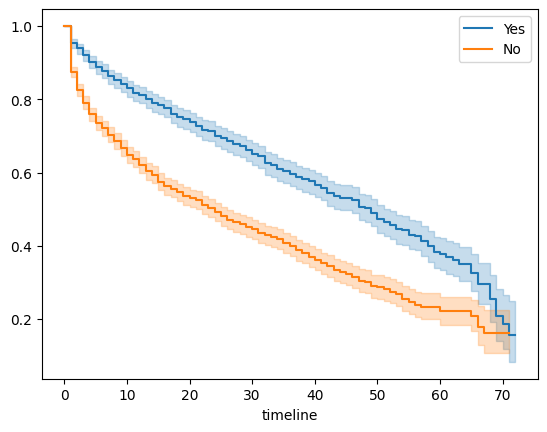

In [22]:


# 分析是否有伴侣（partner）的客户流失差异
plot_km('partner')           # 伴侣状态对客户忠诚度的影响
print_logrank('partner')


,,test_statistic,p,-log2(p)
No,Yes,13.405914,0.000251,11.96099


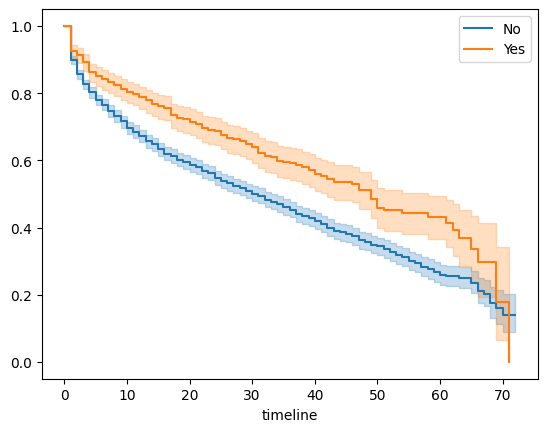

In [23]:

# 分析是否有家属（dependents）对留存的影响
plot_km('dependents')        # 家属数量可能影响服务需求稳定性
print_logrank('dependents')

,,test_statistic,p,-log2(p)
No,Yes,0.778505,0.377599,1.405074


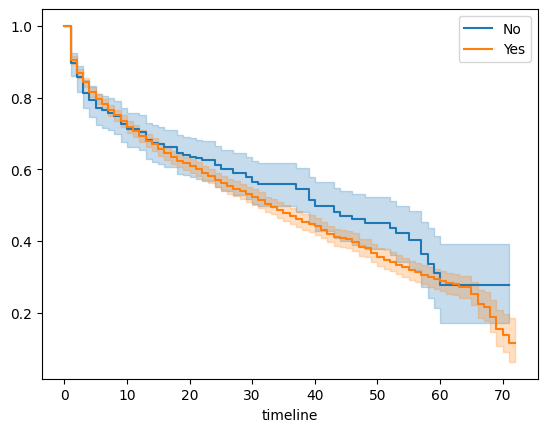

In [24]:

# 分析电话服务（phoneService）基础服务与流失的关联
plot_km('phoneService')      # 基础服务的使用是否影响留存
print_logrank('phoneService')

test_statistic             p    -log2(p)
No               No phone service       35.546250  2.490661e-09   28.580824
                 Yes                   411.225536  1.983168e-91  301.307649
No phone service Yes                    44.056629  3.190116e-11   34.867600

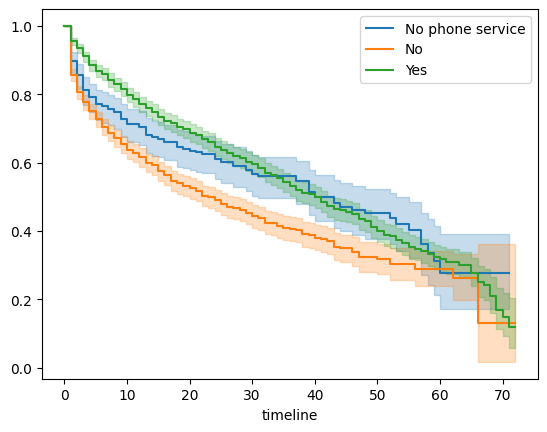

In [25]:

# 分析多线通话（multipleLines）增值服务的效果
plot_km('multipleLines')     # 增值功能对客户保留的作用
print_logrank('multipleLines')

,,test_statistic,p,-log2(p)
DSL,Fiber optic,85.455399,2.369872e-20,65.193753


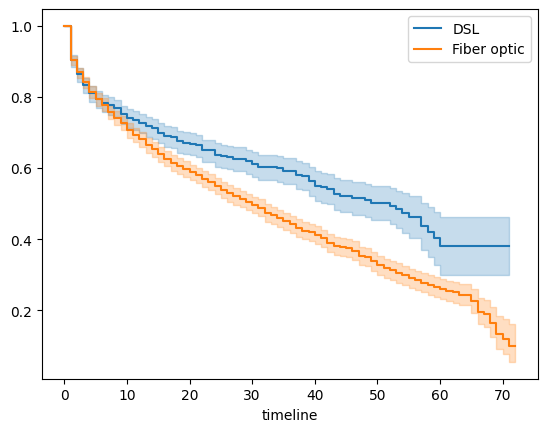

In [26]:

# 分析互联网服务类型（internetService）的影响
plot_km('internetService')   # 不同宽带套餐用户的流失差异（如光纤/DSL）
print_logrank('internetService')

,,test_statistic,p,-log2(p)
No,Yes,140.761789,1.813974e-32,105.442545


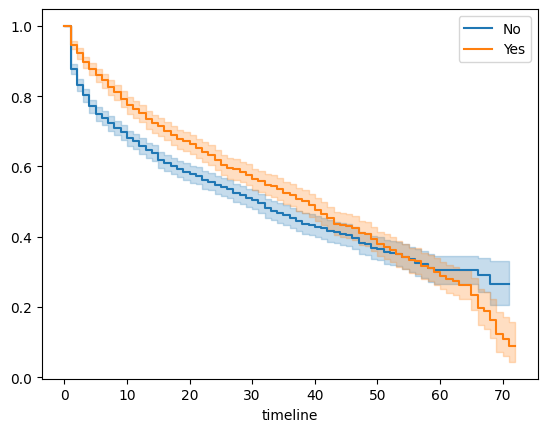

In [27]:

# 分析流媒体电视（streamingTV）附加服务的影响
plot_km('streamingTV')       # 视频内容服务对留存的作用
print_logrank('streamingTV')

,,test_statistic,p,-log2(p)
No,Yes,170.262183,6.484901e-39,126.858111


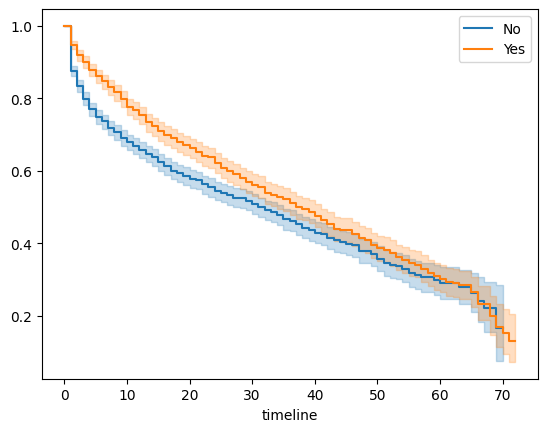

In [28]:


# 分析流媒体电影（streamingMovies）服务的影响
plot_km('streamingMovies')   # 电影资源对客户粘性的影响
print_logrank('streamingMovies')

,,test_statistic,p,-log2(p)
No,Yes,300.455875,2.620909e-67,221.179115


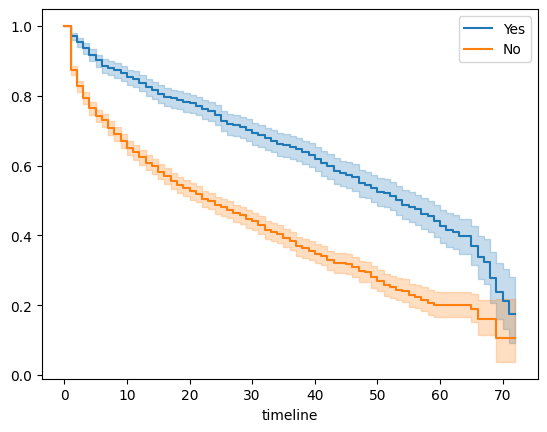

In [29]:

# 分析在线备份服务（onlineBackup）的使用情况
plot_km('onlineBackup')      # 数据备份功能对客户满意度的影响
print_logrank('onlineBackup')

,,test_statistic,p,-log2(p)
No,Yes,169.868512,7.904692e-39,126.572486


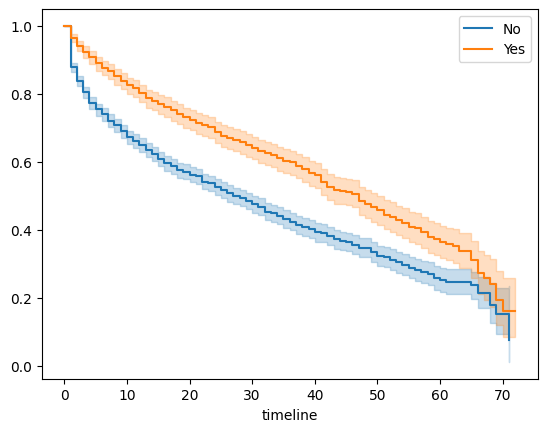

In [30]:
# 分析设备保护计划（deviceProtection）的效果
plot_km('deviceProtection')  # 硬件保险服务是否降低流失
print_logrank('deviceProtection')

,,test_statistic,p,-log2(p)
No,Yes,25.969416,3.468692e-07,21.459105


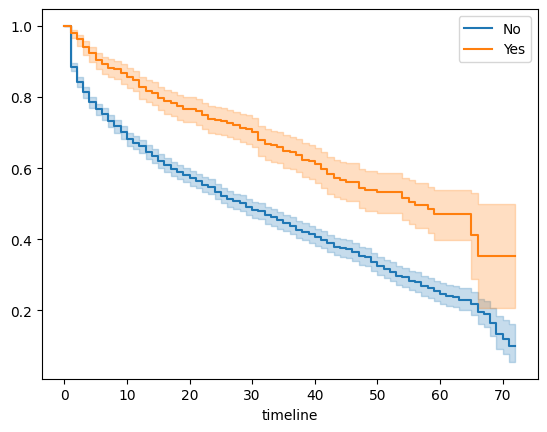

In [40]:
# 分析技术支持服务（techSupport）的影响
plot_km('techSupport')       # 技术支持响应速度对客户保留的重要性
print_logrank('techSupport')

,,test_statistic,p,-log2(p)
No,Yes,25.263459,5.000937e-07,20.931298


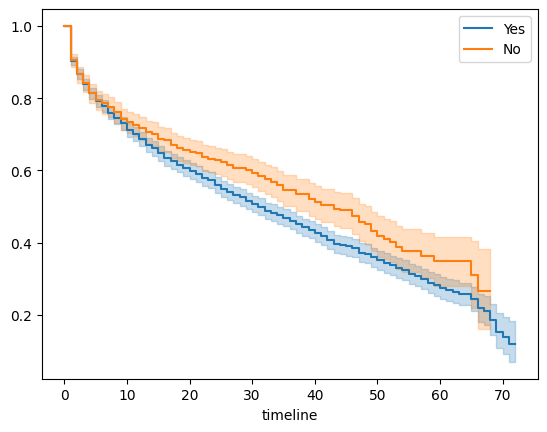

In [33]:
# 分析纸质账单（paperlessBilling）电子化对流失的影响
plot_km('paperlessBilling')
print_logrank('paperlessBilling')

In [37]:
def get_survival_probs(col, val):
    """
    针对数据集中某列（col）的特定值（val）对应的用户群体，拟合 Kaplan-Meier 模型，并返回模型对象。
    """
    ix = telco_pd[col] == val  
    return kmf.fit(T[ix], C[ix], label=val)  
sp_internet_dsl = get_survival_probs('internetService','DSL')
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))
#每一行表示对应时间点的生存概率（如第 9 个月时，75.0833% 的 DSL 用户未流失）。


,DSL
0,1.000000
1,0.902698
2,0.864380
3,0.834702
4,0.810522
5,0.794352
6,0.783900
7,0.776362
8,0.768486
9,0.750833


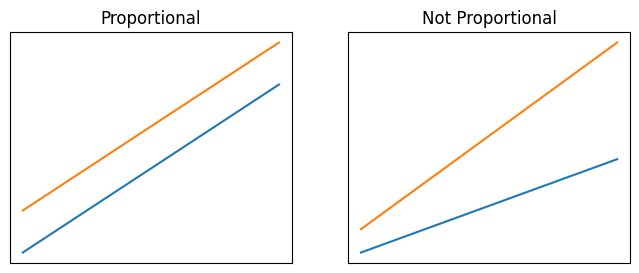

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建一个包含两个子图的画布，尺寸为8x3英寸
# ax1, ax2 是两个子图的坐标轴对象
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# --------------------------------------
# 左图：展示比例关系
# --------------------------------------
# 绘制y=x的直线（斜率1）
ax1.plot([1,2,3,4,5], [1,2,3,4,5])
# 绘制y=x+1的平行直线（保持相同斜率）
ax1.plot([1,2,3,4,5], [2,3,4,5,6])
ax1.title.set_text('Proportional')  # 设置标题
ax1.axes.get_xaxis().set_visible(False)  # 隐藏X轴
ax1.axes.get_yaxis().set_visible(False)  # 隐藏Y轴

# --------------------------------------
# 右图：展示非比例关系
# --------------------------------------
# 绘制y=x的直线（斜率1）
ax2.plot([1,2,3,4,5], [1,2,3,4,5])
# 绘制y=2x的直线（斜率改变，比例被打破）
ax2.plot([1,2,3,4,5], [2,4,6,8,10])
ax2.title.set_text('Not Proportional')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

# 实际使用时需要添加plt.show()来显示图形

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np

from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

# COMMAND ----------

# Load the telco silver table
telco_pd = spark.table('silver_monthly_customers').toPandas()

In [69]:
# 需要独热编码的列名列表（分类变量）
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']

# 对指定列进行独热编码（One-Hot Encoding）
encoded_pd = pd.get_dummies(
    telco_pd,                   # 原始数据集
    columns=encode_cols,        # 指定要编码的列
    prefix=encode_cols,         # 新生成的列名前缀（使用原列名）
    drop_first=False            # 保留所有类别（不删除第一类）
)

# 查看编码后的前5行数据
encoded_pd.head()

,customerID,gender,seniorCitizen,partner,tenure,phoneService,multipleLines,onlineSecurity,deviceProtection,streamingTV,...,dependents_No,dependents_Yes,internetService_DSL,internetService_Fiber optic,onlineBackup_No,onlineBackup_Yes,techSupport_No,techSupport_Yes,paperlessBilling_No,paperlessBilling_Yes
0,7590-VHVEG,Female,0.0,Yes,1.0,No,No phone service,No,No,No,...,True,False,True,False,False,True,True,False,False,True
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,Yes,No,No,...,True,False,True,False,False,True,True,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,No,No,...,True,False,False,True,True,False,True,False,False,True
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,No,Yes,Yes,...,True,False,False,True,True,False,True,False,False,True
4,1452-KIOVK,Male,0.0,No,22.0,Yes,Yes,No,No,Yes,...,False,True,False,True,False,True,True,False,False,True


/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 3351
number of events observed = 1556
   partial log-likelihood = -11315.95
         time fit was run = 2025-04-05 14:41:29 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
dependents_Yes      -0.33      0.72      0.07           -0.47           -0.19                0.63                0.83
internetService_DSL -0.22      0.80      0.06           -0.33           -0.10                0.72                0.90
onlineBackup_Yes    -0.78      0.46      0.06           -0.89           -0.66                0.41                0.52
techSupport_Yes     -0.64      0.53      0.08           -0.79           -0.49                0.46                0.61

                     cmp to      z      p  -log2(p)
covariate                                          
dependents_Yes         0.00  -4.64 <0.005     18.12
internetService_DSL    0.00  -3.68 <0.005     12.07
onlineBackup_Yes       0.00 -13.13 <0.005    128.37
techSupport_Yes        0.00  -8.48 <0.005     55.36
---
Concordance = 0.64
Partial AIC = 22639.90
log-likelihood ratio test = 337.77 on 4 df
-log2(p) of ll-ratio test = 236.24

<Axes: xlabel='HR (95% CI)'>

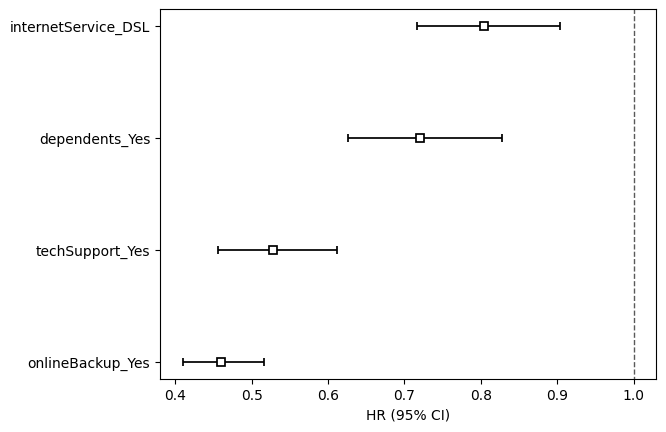

In [71]:
# 选择用于Cox回归的列（生存时间、事件标记、特征变量）
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]

# 将客户流失标记(churn)转换为浮点型（1.0=流失，0.0=未流失）
survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')

# 初始化Cox比例风险模型（置信度95%）
cph = CoxPHFitter(alpha=0.05)

# 拟合模型：tenure是生存时间，churn是事件标记
cph.fit(survival_pd, duration_col='tenure', event_col='churn')

# 打印模型摘要（包括系数、风险比、p值等）
cph.print_summary()

# 可视化各特征的风险比（Hazard Ratios）及其置信区间
cph.plot(hazard_ratios=True)
# 计算多个系数的影响，比如exp(coef)为0.72，及有0.72倍的概率比没有的人留下来

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
internetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
onlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
techSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)




1. Variable 'internetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['techSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://l

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
dependents_Yes      km              1.48   0.22      2.16
                    rank            0.81   0.37      1.44
internetService_DSL km             20.98 <0.005     17.72
                    rank           26.71 <0.005     22.01
onlineBackup_Yes    km             17.80 <0.005     15.31
                    rank           17.47 <0.005     15.07
techSupport_Yes     km              8.09 <0.005      7.81
                    rank           13.76 <0.005     12.23



1. Variable 'internetService_DSL' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['internetService_DSL', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'onlineBackup_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['onlineBackup_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'techSupport_Yes' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['techSupport_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/lat

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

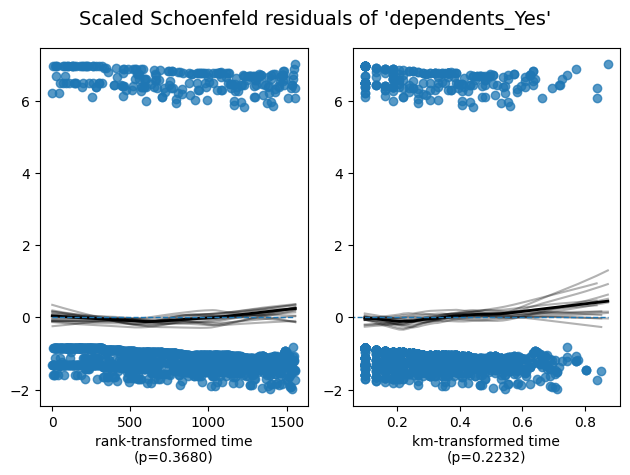

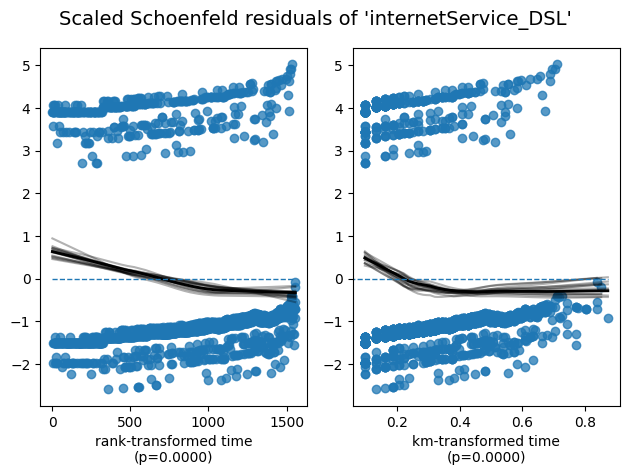

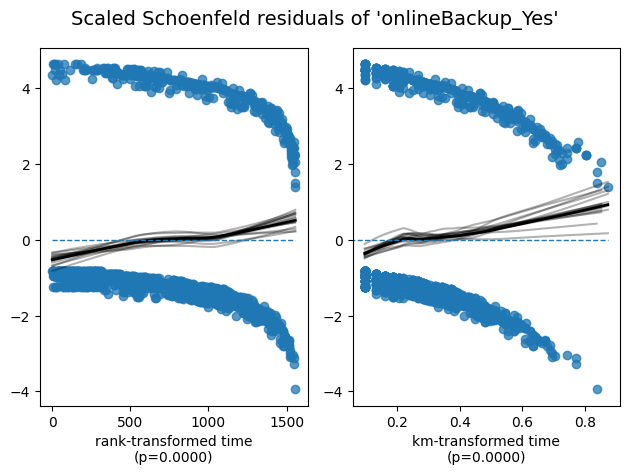

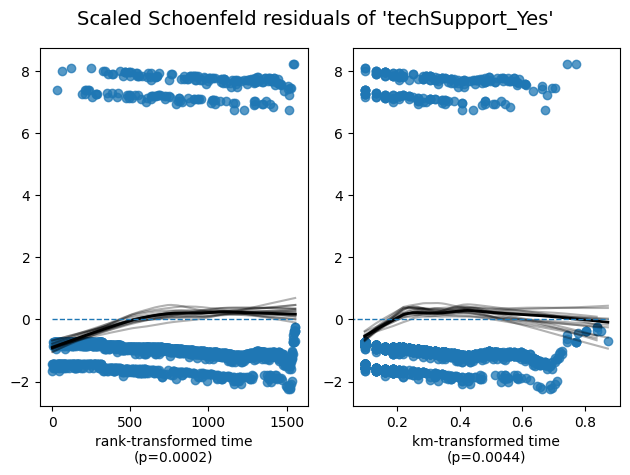

In [72]:

# 第一次检查：仅输出统计结果，不显示图表
cph.check_assumptions(
    survival_pd, 
    p_value_threshold=0.05  # 设置显著性水平为5%，p值低于此则认为违反假设
)

# 第二次检查：显示Schoenfeld残差图，辅助视觉诊断
cph.check_assumptions(
    survival_pd,
    p_value_threshold=0.05,
    show_plots=True  # 绘制各变量残差随时间的变化，检查比例风险假设
)
kmf = KaplanMeierFitter()

T=telco_pd['tenure'] #duration
C=telco_pd['churn'].astype(float) #event observed

kmf.fit(T,C)

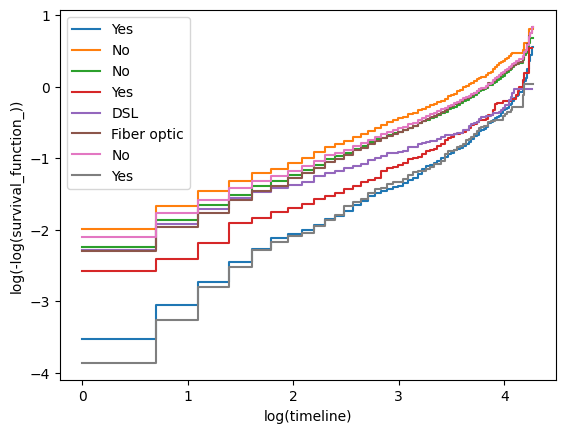

In [73]:
import matplotlib.pyplot as plt
def plot_km_loglog(col):
    """
    绘制对数-对数生存曲线（Log-Log Survival Plots），用于检验比例风险假设
    
    参数:
    - col (str): 分类变量列名（如 'onlineBackup'）
    
    功能:
    1. 对指定列的不同分组（如在线备份用户vs非用户）分别拟合Kaplan-Meier模型
    2. 绘制对数转换后的生存曲线，若曲线近似平行则满足Cox比例风险假设
    
    输出:
    - 各分组的对数-对数生存曲线图（横轴：log(time)，纵轴：log(-log(S(t)))）
    ​方法用途
plot_km_loglog 函数用于 ​检验 Cox 比例风险模型的比例风险假设（Proportional Hazards Assumption）​。
通过绘制 ​对数-对数生存曲线（Log-Log Survival Plots）​，判断不同分组的风险比是否随时间恒定（即满足 Cox 模型的核心假设）。
如何解读：
​满足假设（曲线平行）​：
https://i.stack.imgur.com/5M1nW.png
不同分组的曲线保持近似平行（如上图），说明风险比（HR）随时间恒定，Cox 模型结果可靠。
​违反假设（曲线交叉或发散）​：
https://i.stack.imgur.com/3Xj7R.png
曲线交叉或明显不平行（如上图），说明风险比随时间变化，需调整模型（如分层或引入时间交互项）
    """
    ax = plt.subplot(111)  # 创建单一子图
    for r in telco_pd[col].unique():  # 遍历该列的所有唯一值（如Yes/No）
        ix = telco_pd[col] == r       # 筛选当前分组的数据
        kmf.fit(T[ix], C[ix], label=r)  # 拟合该分组的生存模型
        kmf.plot_loglogs(ax=ax)        # 绘制对数-对数曲线
# COMMAND ----------

plot_km_loglog('onlineBackup')

# COMMAND ----------

plot_km_loglog('dependents')

# COMMAND ----------

plot_km_loglog('internetService')

# COMMAND ----------

plot_km_loglog('techSupport')

In [41]:
encode_cols = ['partner','multipleLines','internetService','onlineSecurity', 'onlineBackup','deviceProtection','techSupport','paymentMethod']

encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)

encoded_pd.head()

,customerID,gender,seniorCitizen,dependents,tenure,phoneService,streamingTV,streamingMovies,contract,paperlessBilling,...,onlineBackup_No,onlineBackup_Yes,deviceProtection_No,deviceProtection_Yes,techSupport_No,techSupport_Yes,paymentMethod_Bank transfer (automatic),paymentMethod_Credit card (automatic),paymentMethod_Electronic check,paymentMethod_Mailed check
0,7590-VHVEG,Female,0.0,No,1.0,No,No,No,Month-to-month,Yes,...,False,True,True,False,True,False,False,False,True,False
1,3668-QPYBK,Male,0.0,No,2.0,Yes,No,No,Month-to-month,Yes,...,False,True,True,False,True,False,False,False,False,True
2,9237-HQITU,Female,0.0,No,2.0,Yes,No,No,Month-to-month,Yes,...,True,False,True,False,True,False,False,False,True,False
3,9305-CDSKC,Female,0.0,No,8.0,Yes,Yes,Yes,Month-to-month,Yes,...,True,False,False,True,True,False,False,False,True,False
4,1452-KIOVK,Male,0.0,Yes,22.0,Yes,Yes,No,Month-to-month,Yes,...,False,True,True,False,True,False,False,True,False,False


In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [45]:

survival_pd = encoded_pd[['churn','tenure','partner_Yes', 'multipleLines_Yes', \
                          'internetService_DSL','onlineSecurity_Yes','onlineBackup_Yes','deviceProtection_Yes','techSupport_Yes',\
                          'paymentMethod_Bank transfer (automatic)','paymentMethod_Credit card (automatic)' ]]

In [48]:

aft = LogLogisticAFTFitter()
aft.fit(survival_pd, duration_col='tenure', event_col='churn')
print("Median Survival Time:{:.2f}".format(np.exp(aft.median_survival_time_)))
aft.print_summary()


Median Survival Time:135.51


<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 3351
number of events observed = 1556
           log-likelihood = -6838.36
         time fit was run = 2025-04-06 09:50:30 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                                
alpha_ deviceProtection_Yes                     0.48      1.62      0.07            0.35            0.62                1.41                1.86
       internetService_DSL                      0.38      1.47      0.08            0.23            0.53                1.26                1.71
       multipleLines_Yes                        0.66      1.94      0.07            0.53            0.80                1.70                2.22
       onlineBackup_Yes                         0.81      2.25      0.07            0.68            0.95                1.97                2.59
       onlineSecurity_Yes                       0.86      2.37      0.09            0.69            1.03                2.00                2.80
       partner_Yes                              0.68      1.97      0.07            0.55            0.81                1.73                2.24
       paymentMethod_Bank transfer (automatic)  0.74      2.10      0.09            0.56            0.92                1.75                2.51
       paymentMethod_Credit card (automatic)    0.80      2.22      0.10            0.61            0.99                1.84                2.68
       techSupport_Yes                          0.69      1.99      0.09            0.52            0.86                1.68                2.36
       Intercept                                1.59      4.91      0.07            1.46            1.72                4.32                5.58
beta_  Intercept                                0.12      1.13      0.02            0.08            0.16                1.08                1.17

                                                cmp to     z      p  -log2(p)
param  covariate                                                             
alpha_ deviceProtection_Yes                       0.00  6.88 <0.005     37.25
       internetService_DSL                        0.00  4.98 <0.005     20.59
       multipleLines_Yes                          0.00  9.64 <0.005     70.70
       onlineBackup_Yes                           0.00 11.63 <0.005    101.50
       onlineSecurity_Yes                         0.00 10.12 <0.005     77.60
       partner_Yes                                0.00 10.21 <0.005     78.93
       paymentMethod_Bank transfer (automatic)    0.00  8.05 <0.005     50.07
       paymentMethod_Credit card (automatic)      0.00  8.36 <0.005     53.81
       techSupport_Yes                            0.00  7.90 <0.005     48.37
       Intercept                                  0.00 24.47 <0.005    436.88
beta_  Intercept                                  0.00  5.71 <0.005     26.42
---
Concordance = 0.73
AIC = 13698.72
log-likelihood ratio test = 877.49 on 9 df
-log2(p) of ll-ratio test = 605.78

<Axes: xlabel='log(accelerated failure rate) (95% CI)'>

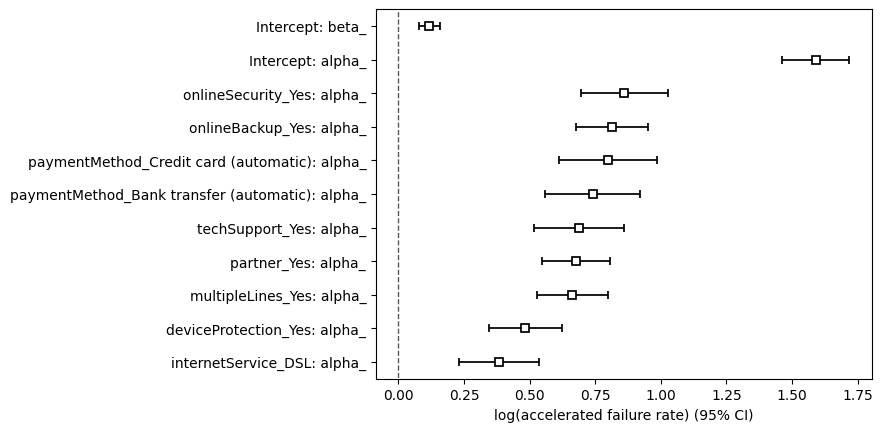

In [49]:
aft.plot()

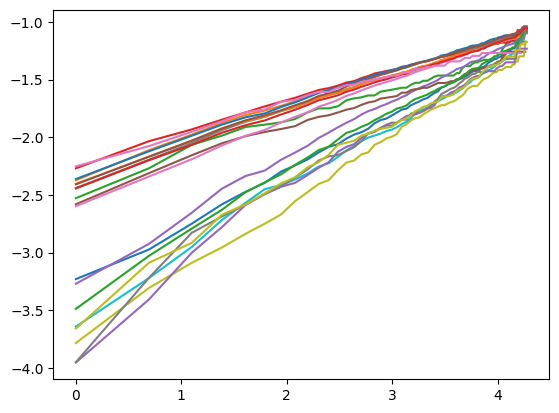

In [50]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

T=telco_pd['tenure'] #duration
C=telco_pd['churn'].astype(float) #event observed

kmf.fit(T,C)
# Utility function for plotting
import matplotlib.pyplot as plt

def plot_km_logOdds(col):
  ax = plt.subplot(111)
  for r in telco_pd[col].unique():
    ix = telco_pd[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    sf = kmf.survival_function_
    sf['failureOdds'] = (np.log(1-sf))/sf
    sf['logTime'] = np.log(sf.index)
    plt.plot(sf['logTime'],sf['failureOdds'])


plot_km_logOdds('partner')
plot_km_logOdds('multipleLines')
plot_km_logOdds('internetService')
plot_km_logOdds('onlineSecurity')
plot_km_logOdds('onlineBackup')
plot_km_logOdds('deviceProtection')
plot_km_logOdds('techSupport')
plot_km_logOdds('paymentMethod')

In [52]:
from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [54]:
encode_cols = ['dependents','internetService','onlineBackup','techSupport','paperlessBilling']

encoded_pd = pd.get_dummies(telco_pd,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)

encoded_pd.head()
survival_pd = encoded_pd[['churn','tenure','dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes']]
survival_pd.loc[:,'churn'] = survival_pd.loc[:,'churn'].astype('float')


In [55]:
# 训练Cox模型
cph = CoxPHFitter(alpha=0.05)
cph.fit(survival_pd, 'tenure', 'churn')

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 3351 total observations, 1795 right-censored observations>

In [57]:
# 定义预测函数（使用固定参数代替widget输入）
def get_payback_df(params=None):
    # 默认参数设置
    default_params = {
        'dependents_Yes': 0,
        'internetService_DSL': 1,
        'onlineBackup_Yes': 0,
        'techSupport_Yes': 1,
        'irr': 0.10  # 内部收益率
    }
    if params:
        default_params.update(params)
    
    # 构建输入数据
    input_df = pd.DataFrame([[
        default_params['dependents_Yes'],
        default_params['internetService_DSL'],
        default_params['onlineBackup_Yes'],
        default_params['techSupport_Yes']
    ]], columns=['dependents_Yes','internetService_DSL','onlineBackup_Yes','techSupport_Yes'])
    
    # 计算生存概率
    survival_function = cph.predict_survival_function(input_df)
    
    # 构建结果表
    cohort_df = pd.concat([
        pd.DataFrame([1.00]),
        survival_function.round(2)
    ]).rename(columns={0: 'Survival Probability'})
    
    cohort_df['Contract Month'] = cohort_df.index.astype(int)
    cohort_df['Monthly Profit'] = 30  # 假设每月利润固定
    cohort_df['Expected Profit'] = (cohort_df['Survival Probability'] * cohort_df['Monthly Profit']).round(2)
    
    # 计算NPV
    irr_monthly = default_params['irr'] / 12
    cohort_df['NPV'] = (cohort_df['Expected Profit'] / ((1 + irr_monthly) ** cohort_df['Contract Month'])).round(2)
    cohort_df['Cumulative NPV'] = cohort_df['NPV'].cumsum()
    
    return cohort_df.set_index('Contract Month')


生存分析结果：
                Survival Probability  Monthly Profit  Expected Profit    NPV  \
Contract Month                                                                 
0                               1.00              30             30.0  30.00   
1                               0.89              30             26.7  26.37   
2                               0.85              30             25.5  24.87   
3                               0.81              30             24.3  23.41   
4                               0.78              30             23.4  22.27   
5                               0.76              30             22.8  21.43   
6                               0.74              30             22.2  20.61   
7                               0.72              30             21.6  19.80   
8                               0.71              30             21.3  19.28   
9                               0.69              30             20.7  18.51   
10                             

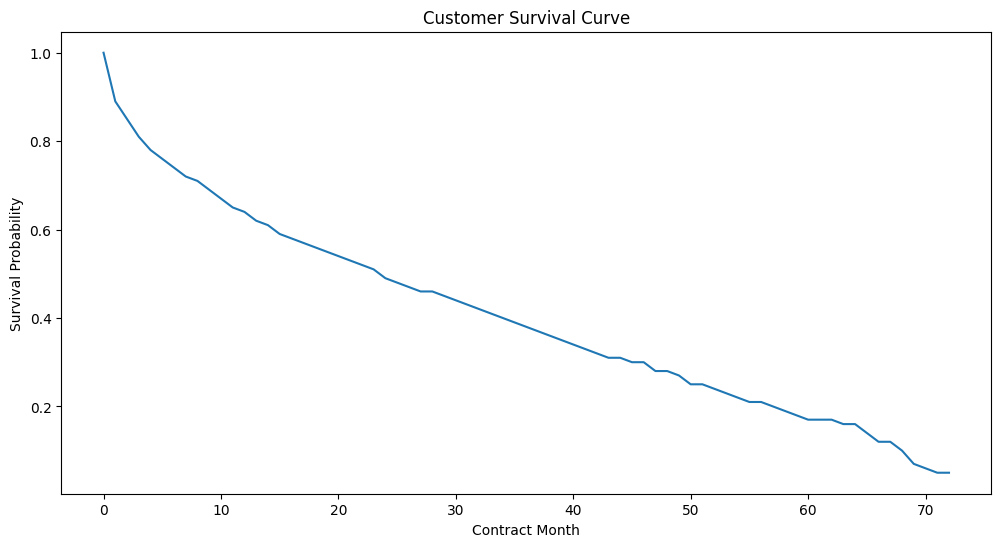

In [56]:


# 示例使用
analysis_df = get_payback_df({
    'techSupport_Yes': 0,
    'irr': 0.15
})

print("\n生存分析结果：")
print(analysis_df.head(12))

# 可视化
plt.figure(figsize=(12, 6))
sns.lineplot(data=analysis_df, x='Contract Month', y='Survival Probability')
plt.title('Customer Survival Curve')
plt.show()
